<a href="https://colab.research.google.com/github/mrarat76/Tensorflow_Practises/blob/main/Tensor_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tensorflow, Transfer Learning ile Fine-Tuning

In [126]:

import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.14.0


In [127]:
!nvidia-smi

Sat Dec  2 18:15:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |   4851MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Helper fonksiyonların oluşturulması

Bu fonksiyonlar tekrar tekrar kullanmak istediğin kodları tekrardan yazmaman için kullanılan fonksiyonlardır.

In [128]:
# helper_functions.py scriptini GitHubdan çekiyoruz.
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# helper fonksiyonunu import ettiriyoruz
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-12-02 18:15:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-02 18:15:49 (97.1 MB/s) - ‘helper_functions.py.4’ saved [10246/10246]



In [129]:
## İlk etapta 10 adet yiyecek classını içeren az veriye sahip datayla çalışacağız.

# Datanın %10nunu alıyoruz.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2023-12-02 18:15:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.4’

10_food_classes_10_ 100%[===================>] 160.74M   207MB/s    in 0.8s    

2023-12-02 18:15:50 (207 MB/s) - ‘10_food_classes_10_percent.zip.4’ saved [168546183/168546183]



In [130]:
#İnceliyoruz.
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [131]:
# Train ve test directoryleri değişkenlere atıyoruz.
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [132]:
# Data imputları oluşturuyoruz.
import tensorflow as tf
IMG_SIZE = (224, 224) # resim boyutunu tanımlıyoruz
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # etiketlerin cinsi
                                                                            batch_size=32) # batch_size varsayılan olarak 32 olarak ayarlandı.İyi bir sayı olduğu aşikar.
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [133]:
# Train datasının tipini kontrol ediyoruz.
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


Yukarıdaki çıktıda:

(None, 224, 224, 3), görüntülerimizin tensör şeklini temsil eder, burada None, grup boyutunu ifade ederken, 224 yükseklik (ve genişlik) ve 3 renk kanalını (kırmızı, yeşil, mavi) belirtir.
(None, 10), etiketlerin tensör şeklini temsil eder, burada None, grup boyutunu ifade ederken, 10 ise olası etiketlerin sayısını (10 farklı yemek sınıfı) belirtir.
Görüntü tensörleri ve etiketler, tf.float32 veri türündedir.
None olan batch_size, yalnızca model eğitimi sırasında kullanıldığı için vardır. None'yi, image_dataset_from_directory() işlevinden alınan batch_size parametresi ile doldurulmayı bekleyen bir yer tutucu olarak düşünebilirsiniz.

tf.data.Dataset API kullanmanın başka bir avantajı da onunla birlikte gelen ilişkili yöntemlerdir.

Örneğin, çalıştığımız sınıfların adını bulmak istiyorsak, class_names özniteliğini kullanabiliriz.







In [134]:
# Datanın batchinden bir örnek görelim
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.59714294e+02 1.28714294e+02 7.40714264e+01]
   [1.52000000e+02 1.20000000e+02 5.92857094e+01]
   [1.52994904e+02 1.19780617e+02 4.81377525e+01]
   ...
   [1.23000000e+02 1.00000000e+02 8.60000000e+01]
   [1.29071396e+02 1.03071388e+02 9.00713882e+01]
   [1.23086685e+02 9.70866852e+01 8.40866852e+01]]

  [[1.69382645e+02 1.38051025e+02 8.50000000e+01]
   [1.59214294e+02 1.29142853e+02 6.75000000e+01]
   [1.48729584e+02 1.18102036e+02 4.75306129e+01]
   ...
   [1.24714310e+02 1.01714310e+02 8.57143097e+01]
   [1.26862206e+02 1.03862206e+02 8.78622055e+01]
   [1.25474525e+02 9.94745255e+01 8.44745255e+01]]

  [[1.67642853e+02 1.35994888e+02 8.60000000e+01]
   [1.68142853e+02 1.37127548e+02 8.07857132e+01]
   [1.57525513e+02 1.26096939e+02 5.90969391e+01]
   ...
   [1.32168350e+02 1.09428551e+02 9.07856903e+01]
   [1.26729546e+02 1.03943825e+02 8.53009720e+01]
   [1.23219467e+02 1.00433754e+02 8.17908936e+01]]

  ...

  [[1.90428528e+02 1.81785736e+02 1.59428528e+02]
   [1

##Model 0: Transfer Learning Modeli Keras APIsi ile yapılması


Aşağıdaki adımları takip edeceğiz:

tf.keras.applications.efficientnet_v2 gibi bir hedef model seçerek önceden eğitilmiş bir temel model nesnesini oluşturun. include_top parametresini False olarak ayarlarız (bunu yapmamızın nedeni, model için kendi üst katmanımızı oluşturacağımız için, bu üst katman modelin çıkış katmanlarıdır).

Temel modelin trainable özniteliğini False olarak ayarlayarak önceden eğitilmiş modelin tüm ağırlıklarını dondurun.

Modelimiz için bir giriş katmanı tanımlayın; örneğin, modelimizin hangi veri şeklini beklemesi gerekiyor?

[İsteğe bağlı] Modelimize girişleri normalize edin, eğer gerekiyorsa. Bazı görüntü işleme modelleri, örneğin ResNetV250 gibi, girişlerinin 0 ile 1 arasında olmasını gerektirir.


Girişleri temel modele iletilir.

Temel modelin çıktılarını çıkış aktivasyon katmanı ile uyumlu bir şekle (temel model çıkış tensörlerini etiket tensörleri ile aynı şekle) dönüştürün. Bu işlem, tf.keras.layers.GlobalAveragePooling2D() veya tf.keras.layers.GlobalMaxPooling2D() kullanılarak yapılabilir, ancak özellikle pratikte daha yaygın olarak kullanılanı ilk seçenektir.

Uygun aktivasyon fonksiyonu ve nöron sayısı ile tf.keras.layers.Dense() kullanarak bir çıkış aktivasyon katmanı oluşturun.

Giriş ve çıkış katmanlarını tf.keras.Model() kullanarak birleştirerek bir model oluşturun.

Modeli uygun kayıp fonksiyonu ve bir optimizatör seçerek derleyin.

Modeli istediğiniz sayıda dönem için ve gerekli geriçağırıcılarla (bizim durumumuzda TensorBoard geriçağırıcısı ile başlayacağız) uygun şekilde eğitin.

In [135]:
# 1. Keras ile model oluşturma
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Modelin Dondurulması
base_model.trainable = False

# 3. Modele verilecek inputların oluşturulması.
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. ResNet50V2 kullanıyorsanız yakınsamayı hızlandırmak için bunu ekleyin, EfficientNetV2 için kaldırın
 # x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(girişler)

# 5. Inputların base_model'e iletilmesi (not: tf.keras.applications kullanıldığında EfficientNetV2 girişlerinin normalleştirilmesine gerek yoktur)
x = base_model(inputs)
# Veri şeklini base_model'e aktardıktan sonra kontrol edilmesi
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Çıkış etkinleştirme katmanını oluşturun

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Girdileri çıktılarla bir modelde birleştirin

model_0 = tf.keras.Model(inputs, outputs)

# 9. Modelin derlenmesi
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Modelin fitlenmesi
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20231202-181556
Epoch 1/5
24/24 [==============================] - 15s 349ms/step - loss: 1.8926 - accuracy: 0.4120 - val_loss: 1.3675 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - 4s 170ms/step - loss: 1.1603 - accuracy: 0.7533 - val_loss: 0.9371 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 3s 127ms/step - loss: 0.8459 - accuracy: 0.8093 - val_loss: 0.7288 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 4s 138ms/step - loss: 0.6867 - accuracy: 0.8493 - val_loss: 0.6491 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 4s 170ms/step - loss: 0.6075 - accuracy: 0.8587 - val_loss: 0.5604 - val_accuracy: 0.8635


In [136]:
# Modelimizdeki layerları kontrol ediyoruz
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_13
1 rescaling_12
2 normalization_12
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
4

In [137]:
base_model.summary()


Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_12 (Rescaling)    (None, None, None, 3)        0         ['input_13[0][0]']            
                                                                                                  
 normalization_12 (Normaliz  (None, None, None, 3)        0         ['rescaling_12[0][0]']        
 ation)                                                                                           
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [138]:
model_0.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_______________

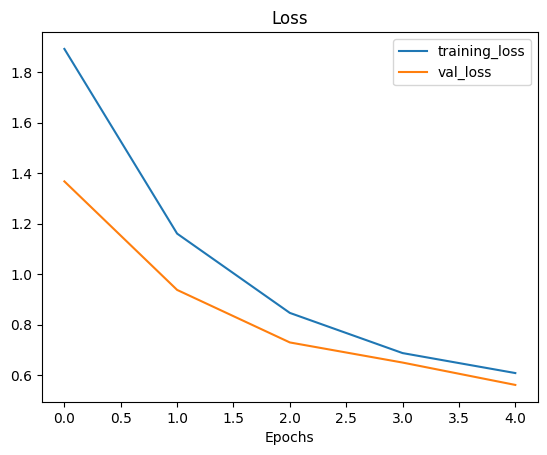

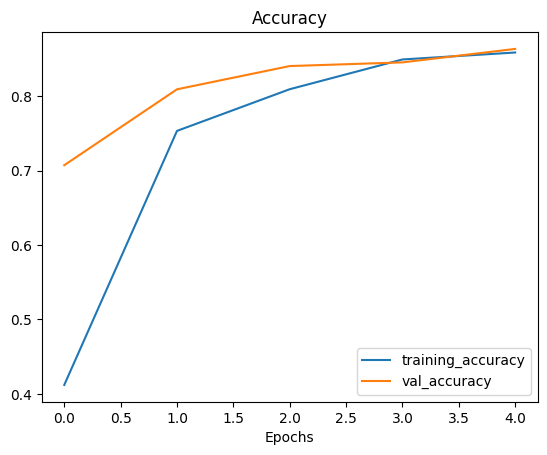

In [139]:
plot_loss_curves(history_10_percent)


# Eğitilmiş bir modelden feature vector alma
tf.keras.layers.GlobalAveragePooling2D() katmanı, iç eksenlerdeki değerlerin ortalamasını alarak bir 4D tensörü 2D tensöre dönüştürür.


In [140]:

# GİRİŞ TENSORLERİNİN TANIMLANMASI ( efficientnetv2-b0 çıktısının aynısı)
input_shape = (1, 4, 4, 3)

# Random bir tensor oluşturulması
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

#Rastgele tensörü  global average pooling 2B katmanından geçirin
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Farklı tensörlerin şekillerini kontrol edin

print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [141]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Bu işlem, temel modelin çıktısını sadece çıkış katmanımızın (tf.keras.layers.Dense()) giriş şekil gereksinimleriyle uyumlu hale getirmekle kalmaz, aynı zamanda temel model tarafından bulunan bilgiyi daha düşük boyutlu bir özellik vektörüne yoğunlaştırır.

 Not: Özellik çıkarma transfer öğrenme bu adıyla adlandırılıyor çünkü genellikle önceden eğitilmiş bir model, bir özellik vektörü (uzun bir sayılar tensörü, bizim durumumuzda bu, tf.keras.layers.GlobalAveragePooling2D() katmanının çıktısıdır) çıkarır ve bu vektörü desenlerin çıkarılması için kullanabilirsiniz.

 Pratik: Yukarıdaki hücrede olduğu gibi aynı işlemi tf.keras.layers.GlobalMaxPool2D() için yapın.







Daha az veri ile transfer learning denemeleri

In [142]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"


--2023-12-02 18:16:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.6’

10_food_classes_1_p 100%[===================>] 127.42M   196MB/s    in 0.6s    

2023-12-02 18:16:34 (196 MB/s) - ‘10_food_classes_1_percent.zip.6’ saved [133612354/133612354]



In [143]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [144]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Doğrudan modele sentetik veri ile üretilen veriyi ekleme


In [145]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

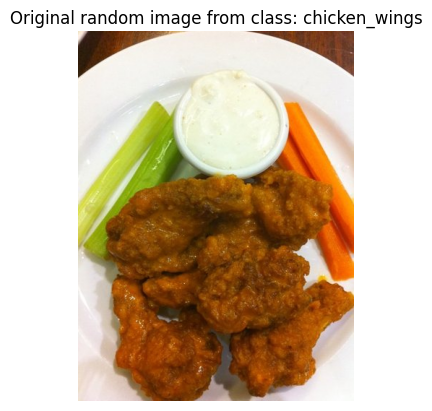

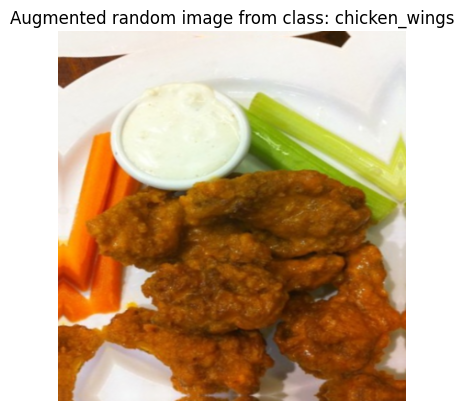

In [146]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);
# Verinin sentetiklenmesi
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [147]:
##Model 1 Özellik çıkarımı ile transfer learning denemesi

input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                                                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231202-181640
Epoch 1/5
3/3 [==============================] - 14s 2s/step - loss: 2.3664 - accuracy: 0.1286 - val_loss: 2.2512 - val_accuracy: 0.1530
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1455 - accuracy: 0.2714 - val_loss: 2.1440 - val_accuracy: 0.2204
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9658 - accuracy: 0.3714 - val_loss: 2.0365 - val_accuracy: 0.2763
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8530 - accuracy: 0.4286 - val_loss: 1.9517 - val_accuracy: 0.3043
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6957 - accuracy: 0.4714 - val_loss: 1.9027 - val_accuracy: 0.3059


In [ ]:
model_1.summary()


In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

In [ ]:
plot_loss_curves(history_1_percent)


In [ ]:
#Model 2 %10 data ve sentetik data ile

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [148]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [149]:

# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [ ]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model

        model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()


In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)


In [150]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231202-181715


NameError: ignored

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug


In [ ]:

# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)


In [ ]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

In [ ]:
results_10_percent_data_aug == loaded_weights_model_results


In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))


In [ ]:
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))


In [ ]:
#Model 3 var olan modele %10 data ile fine tuning yapma

In [ ]:
model_2.layers


In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

In [ ]:
model_2.summary()


In [ ]:
model_2_base_model = model_2.layers[2]
model_2_base_model.name

In [ ]:
print(len(model_2_base_model.trainable_variables))

In [ ]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
print(len(model_2.trainable_variables))

In [ ]:
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately


In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


In [ ]:

compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

In [ ]:
#Model 4: Bütün veri ile fine tuning yapma

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
walk_through_dir("10_food_classes_all_data")

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

In [ ]:
model_2.evaluate(test_data)


In [ ]:
results_fine_tune_10_percent


In [ ]:
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning


In [ ]:
model_2.load_weights(checkpoint_path)


In [ ]:
model_2.summary()


In [ ]:
print(len(model_2.trainable_variables))


In [ ]:
model_2.evaluate(test_data)


In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)


In [ ]:
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)


In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])


In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


In [ ]:

results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

In [ ]:
results_fine_tune_10_percent

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)